# What Happened with Code Violations in Seattle?

This is part 1 of a project I initially started as a way of helping me find a new apartment around Seattle. As a recent-grad, I wanted to find a place around U-District to keep me close to the University + Downtown for potential work. U-District is not a pretty place, but go 20 minutes away from campus in any direction and things look much better.

But why stop there? The data was already there, so I pretty quickly expanded the scope of the project. Right now it's a way of:
<ol>
    <li>Getting an inkling of the quality of each neighborhood</li>
    <li>Learning more about using Pandas</li> 
    <li>Figuring out why the number of code violation cases drastically dropped in 2010</li> 
</ol>

I borrowed ideas from a [blog post](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) by data scientist Jake Vanderplas at the University of Washington eScience Institute. He does a very thorough analysis of timeseries data of cyclists in Seattle instead.

## The Data

I use three datasets in this writeup. One contains [code violations](https://data.seattle.gov/Community/Code-Violation-Cases/dk8m-pdjf) in the Seattle neighborhoods going back ~15 years. There are 33918 individual code violation cases of various types in this dataset. The other two contain building permits ([here](https://data.seattle.gov/Permitting/Building-Permits-Current/mags-97de) and [here](https://data.seattle.gov/Permitting/Building-Permits-Older-than-5-years/47eb-r92t)) applied for and issued by the city for various projects in the past ~10 years. There are 81840 permit applications in this dataset, fewer of which were accepted for permitting.

## The Analysis

I'll start by importing Pandas, Matplotlib, and Numpy to read in the datasets, then plot & perform operations with it. The data comes as a CSV file, and Pandas as a fabulous feature for reading in and parsing well formatted CSV files. I choose not to parse the date columns here because I will be manually creating timeseries from certain columns in a minute.

In [152]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') #Matplotlib 'ggplot' style sheet for all subsequent plots

violations = pd.read_csv('violations.csv', header=0)

Here are all the code violation cases submitted to the city. These are complaints that were initially issued by residents and may or may not have been followed up on.

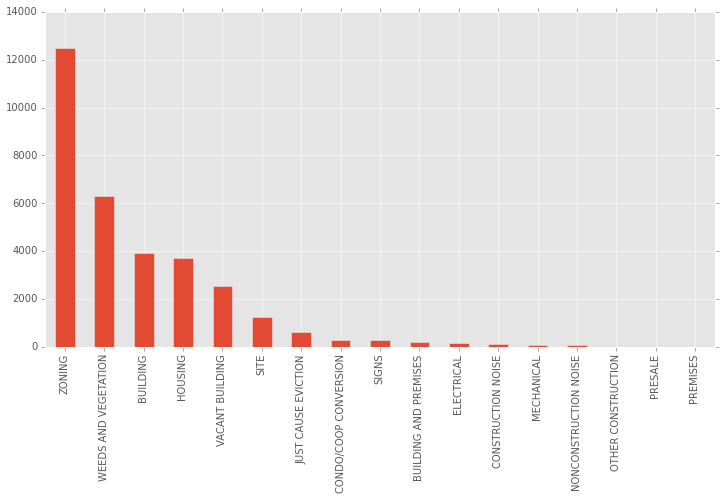

In [158]:
violations['Case Group'].value_counts().plot(kind='bar', figsize=(12,6))

There are an overwhelming majority of cases of zoning violations and (a little surprisingly) very few construction noise violations, the exact numbers being:

In [125]:
violations['Case Group'].value_counts()

ZONING                   12476
WEEDS AND VEGETATION      6291
BUILDING                  3905
HOUSING                   3699
VACANT BUILDING           2522
SITE                      1265
JUST CAUSE EVICTION        608
CONDO/COOP CONVERSION      305
SIGNS                      301
BUILDING AND PREMISES      212
ELECTRICAL                 176
MECHANICAL                  92
CONSTRUCTION NOISE          84
NONCONSTRUCTION NOISE       54
OTHER CONSTRUCTION          11
PRESALE                      8
PREMISES                     4
dtype: int64

At a glance, it looks like the majority of these violations are from people complaining about their neighbors!

Each piece of data consists of the type of violation, the location at which the violation took place, the date on which the city opened a case, and outcomes of followup inspections. Though I'll ultimately be using the dates on which cases were created, it's at least interesting to see a little about how inspections are handled by the city as well.

A good way to visualize this data is to setup a timeseries of it, which Pandas is perfect for. At a first glance, the dates on which cases are created aren't regular, and neither are the dates where agents followup on those cases. By counting up all of the cases created/inspected on a given day, I can create a timeseries over the 10 years. Pandas dataframes offer a very convenient way of compiling the two timeseries.

In [153]:
case_counts = violations['Date Case Created'].value_counts()
inspec_counts = violations['Last Inspection Date'].value_counts()

case_dates = pd.to_datetime(case_counts.index, format='%m/%d/%Y')
inspec_dates = pd.to_datetime(inspec_counts.index, format='%m/%d/%Y')

inspections = pd.DataFrame({'Case Creation': pd.Series(case_counts.tolist(), index=case_dates),
                           'Followup Inspection': pd.Series(inspec_counts.tolist(), index=inspec_dates)})
inspections.tail(5)

,Case Creation,Followup Inspection
2015-08-04,15,18
2015-08-05,8,4
2015-08-06,11,13
2015-08-23,NaN,1
2015-12-05,NaN,1


Notice that there are NaNs all throughout where there are either no case creations or followup inspections. I can fix this with a simple replacement of NaNs with 0.

In [154]:
inspections = inspections.fillna(0)

And now the pretty part. Since plotting day by day is messy, I can use Pandas to resample up to monthly and annual cadences.

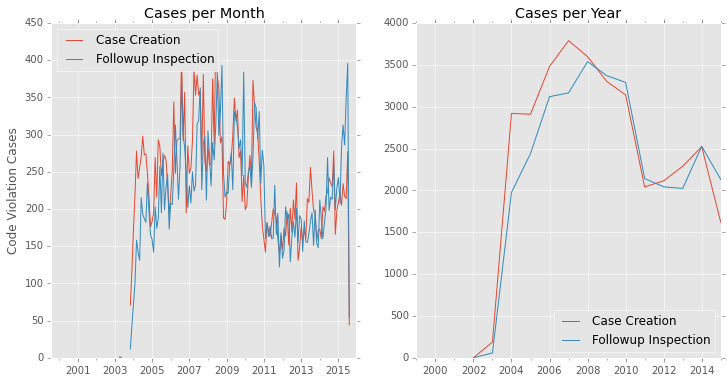

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].set_ylabel('Code Violation Cases')
inspections.resample('M',how='sum').plot(ax=axes[0]).set_title('Cases per Month')
inspections.resample('A',how='sum').plot(ax=axes[1]).set_title('Cases per Year')

Interestingly enough, there are significantly more cases created than are inspected by the city. This could be due to a number of things, such as certain cases not requiring in-person followup.
However, most surprisingly is the huge drop in cases, both created and followed-up, around 2010. There are likely seasonal variations, but of course that doesn't explain the drop at all.
A good thing to look at before anything big is the seasonal variation.

By setting up a season dictionary for the months and pulling out the season for both each day and each case, I can take a closer look at how important seasons are to this.

In [160]:
SEASON = {1:'Winter', 2:'Winter', 3:'Winter', 4:'Spring', 5:'Spring', 6:'Spring', 
          7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', 11:'Autumn', 12:'Winter'}

day_seasons = pd.Series([SEASON[i] for i in case_dates.month])
case_seasons = pd.Series([SEASON[i] for i in pd.DatetimeIndex(violations['Date Case Created']).month])

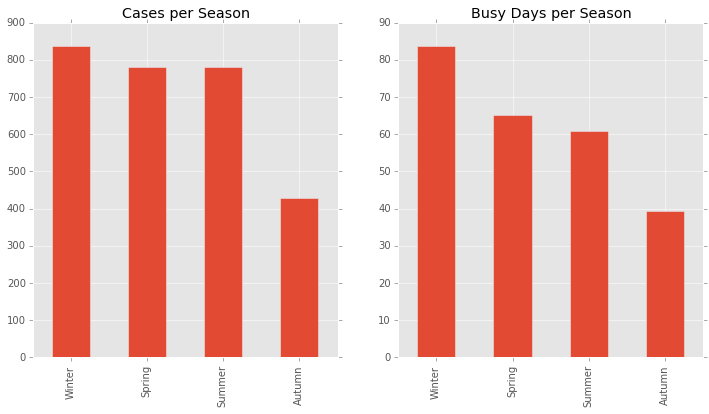

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
(case_seasons.value_counts() / 12.).plot(kind='bar', ax=axes[0])
(day_seasons.value_counts() / 12.).plot(kind='bar', ax=axes[1])
axes[1].set_title('Busy Days per Season')
axes[0].set_title('Cases per Season')

Winter has a small lead in the sheer number of cases created per season, but it has a pretty sizable lead on the number of days the city takes to perform an initial followup on the cases. This can serve as an indicator that there is seasonal variation that can be subtracted out

In [104]:
WEEKDAY = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 
            4:'Fri', 5:'Sat', 6:'Sun'}

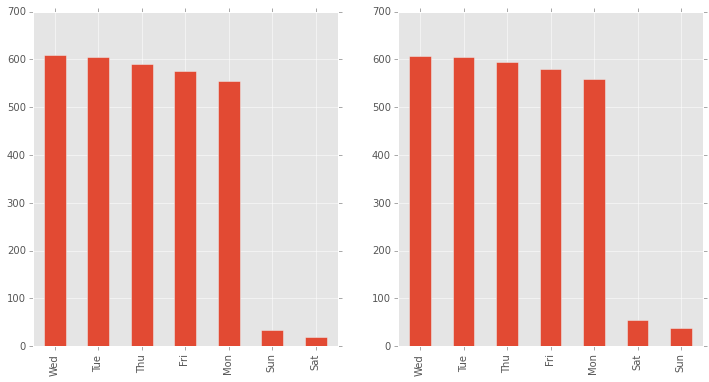

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
pd.Series([WEEKDAY[i] for i in case_dates.weekday]).value_counts().plot(kind='bar', ax=axes[0])
pd.Series([WEEKDAY[i] for i in inspec_dates.weekday]).value_counts().plot(kind='bar', ax=axes[1])

In [106]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

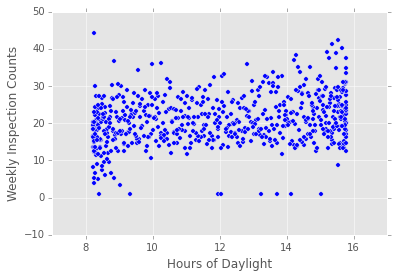

In [107]:
inspec_weekly = inspections['Total Inspections'].resample('W').dropna()
daylight_weekly = inspec_weekly.dropna().index.map(hours_of_daylight)

inspec_weekly = inspec_weekly[:,np.newaxis]
daylight_weekly = daylight_weekly[:,np.newaxis]

plt.scatter(daylight_weekly, inspec_weekly)
plt.xlabel('Hours of Daylight')
plt.ylabel('Weekly Inspection Counts')

In [108]:
from sklearn.linear_model import LinearRegression

fit = LinearRegression().fit(daylight_weekly, inspec_weekly)
weekly_fit = fit.predict(daylight_weekly)

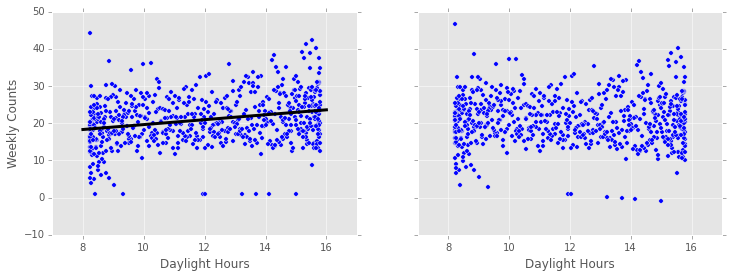

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
xspace = np.linspace(8,16)[:,np.newaxis]

axes[0].scatter(daylight_weekly, inspec_weekly)
axes[0].plot(xspace, fit.predict(xspace), 'k', linewidth=3)
axes[1].scatter(daylight_weekly, inspec_weekly - weekly_fit + np.mean(weekly_fit))

axes[0].set_xlabel('Daylight Hours') ; axes[0].set_ylabel('Weekly Counts')
axes[1].set_xlabel('Daylight Hours')

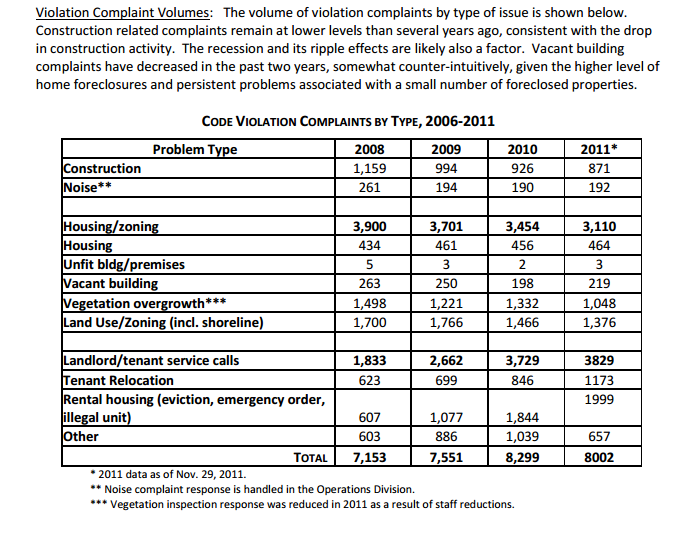

In [110]:
from IPython.display import Image
Image(filename='violations.png')

In [111]:
construction1 = pd.read_csv('construction.csv', header=0, parse_dates=True)
construction2 = pd.read_csv('construction2.csv', header=0, parse_dates=True)
construction = pd.concat([construction1,construction2])

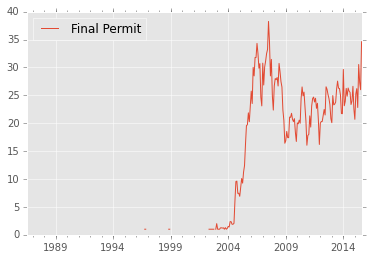

In [112]:
permit_counts = construction['Issue Date'].value_counts()
permit_dates = pd.to_datetime(permit_counts.index, format='%m/%d/%Y')

permits = pd.DataFrame({'Final Permit': pd.Series(permit_counts.tolist(), index=permit_dates)})
permits.resample('M').plot()

In [113]:
data = inspections.join(permits).resample('W').fillna(0)
data = data.sort()
columns = ['Final Permit']

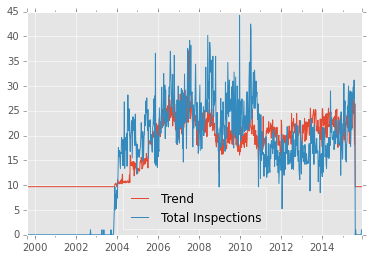

In [114]:
from sklearn.linear_model import LinearRegression
fit = LinearRegression().fit(data[columns]['2005-08-16':],data['Total Inspections']['2005-08-16':])
data['Trend'] = fit.predict(data[columns])
data[['Trend','Total Inspections']].plot()

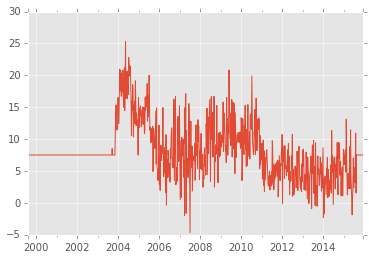

In [115]:
test = (data['Case Creation'] - data['Trend'] + data['Trend'].mean())
test.plot()

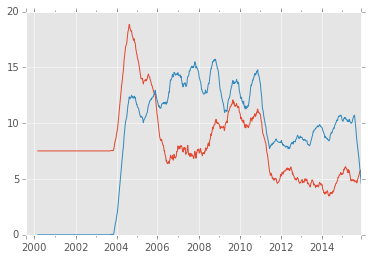

In [116]:
pd.stats.moments.rolling_mean(test, 30).plot()
pd.stats.moments.rolling_mean(data['Case Creation'], 30).plot()

In [151]:
construction['Application Date'].order()

34519    01/01/2004
20491    01/02/2007
20492    01/02/2007
20493    01/02/2007
20494    01/02/2007
20495    01/02/2007
20496    01/02/2007
20497    01/02/2007
35892    01/02/2008
35893    01/02/2008
35894    01/02/2008
13311    01/02/2008
13312    01/02/2008
13313    01/02/2008
13314    01/02/2008
13315    01/02/2008
13316    01/02/2008
13317    01/02/2008
13318    01/02/2008
13319    01/02/2008
13320    01/02/2008
13321    01/02/2008
13322    01/02/2008
13323    01/02/2008
13324    01/02/2008
13325    01/02/2008
13326    01/02/2008
13327    01/02/2008
7460     01/02/2009
7461     01/02/2009
            ...    
46858           NaN
46859           NaN
46860           NaN
46861           NaN
46862           NaN
46863           NaN
46864           NaN
46865           NaN
46866           NaN
46867           NaN
46868           NaN
46869           NaN
46870           NaN
46871           NaN
46872           NaN
46873           NaN
46874           NaN
46875           NaN
46876           NaN
